# Number Count Asymmetry

In [1]:
import astropy
from scipy.optimize import minimize, curve_fit
from gaia_tools import query
import emcee
import corner
from scipy.interpolate import interp1d
from galpy.util import bovy_plot
from scipy.interpolate import CubicSpline
from galpy.util import bovy_coords, bovy_plot
import pandas

from random import randint

import warnings
warnings.simplefilter("ignore")

import matplotlib.colors as mcolors

%pylab inline

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443
Populating the interactive namespace from numpy and matplotlib


In [2]:
bprpMg_query='''SELECT -5*LOG(1000/parallax)/LOG(10)+5+phot_g_mean_mag AS mg, bp_rp FROM gaiadr2.gaia_source
WHERE parallax_over_error > 10
AND phot_g_mean_flux_over_error>50
AND phot_rp_mean_flux_over_error>20
AND phot_bp_mean_flux_over_error>20
AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
AND visibility_periods_used>8
AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))
AND parallax > 4'''

query.cache.nickname(bprpMg_query,'cmd_query')

True

In [3]:
out= query.query(bprpMg_query,local=False)
mg= out['mg']; bprp= out['bp_rp']
bprp_edges= arange(0.7,2.1+0.1,0.1)
Mg_edges= zeros((len(bprp_edges)-1,2))

In [4]:
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))
  
def findbin(mag,around):
    y,x= histogram(mag,bins=101)
    x= [(x[i]+x[i+1])/2. for i in range(101)]
    popt,pcov = curve_fit(gaus,x[argmax(y)-around[0]:argmax(y)+around[1]],y[argmax(y)-around[0]:argmax(y)+around[1]],p0=[350000.,x[argmax(y)],1.])

    xmodel= linspace(-3,15,10000)
    mean= popt[1]
    var= abs(popt[2])
    
    return [round(mean-2.*var,2),round(mean+2.*var,2)]
    

for i in range(len(bprp_edges)-1):
    a= [5,7] if (i<13) else [17,17]
    if (i>16):
        a=[31,31]
    
    Mg_edges[i]= findbin(mg[(bprp>bprp_edges[i])*(bprp<bprp_edges[i+1])],around=a)

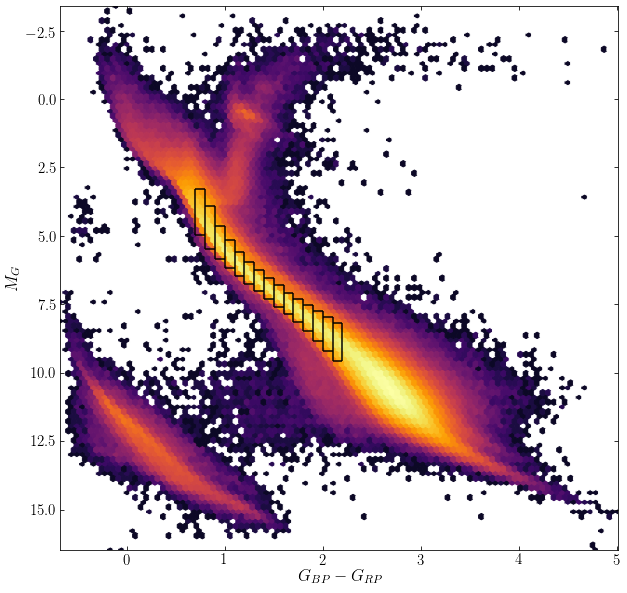

In [5]:
mgplot= zeros((len(bprp_edges)+1,2))
mgplot[1:-1]= Mg_edges; mgplot[0]=Mg_edges[0]; mgplot[-1]=Mg_edges[-1]

colors = np.vstack(([1.,1.,1.,1.], plt.cm.inferno(np.linspace(0, 1, 256))))
cmap = mcolors.LinearSegmentedColormap.from_list('colormap', colors)

bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(10,10)

hexbin(bprp,mg,bins='log',cmap=cmap,gridsize=100)
gca().invert_yaxis()

for i in range(len(bprp_edges)):
    vlines(bprp_edges[i],mgplot[i][0],mgplot[i+1][1],color='k')
    if i<len(bprp_edges)-1:
        hlines(mgplot[i+1][0],bprp_edges[i],bprp_edges[i+1],color='k') 
        hlines(mgplot[i+1][1],bprp_edges[i],bprp_edges[i+1],color='k')
        
tick_params(axis='both')
ylabel(r'$M_G$')
xlabel(r'$G_{BP}-G_{RP}$')

savefig('cmd.pdf',bbox_inches='tight')

In [6]:
queries= []
for i in range(len(Mg_edges)):
    queries.append("""SELECT cos(RADIANS(b))*(1/parallax)*cos(RADIANS(l)) AS x, 
cos(RADIANS(b))*(1/parallax)*sin(RADIANS(l)) AS y, 
(1/parallax)*sin(RADIANS(b)) AS z
FROM gaiadr2.gaia_source
WHERE phot_g_mean_mag BETWEEN 7 AND 17
AND (1/parallax)*cos(RADIANS(b)) < 0.25 
AND parallax_over_error > 5
AND bp_rp BETWEEN {0:.2f} AND {1:.2f}
AND -5*LOG(1000/parallax)/LOG(10)+5+phot_g_mean_mag BETWEEN {2:.1f} AND {3:.1f}"""\
          .format(bprp_edges[i],
                  bprp_edges[i+1],
                  Mg_edges[i,0],
                  Mg_edges[i,1]))

#If You want to add quality cuts, add this to the above query
"""
AND phot_g_mean_flux_over_error>50
AND phot_rp_mean_flux_over_error>20
AND phot_bp_mean_flux_over_error>20
AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
AND visibility_periods_used>8
AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))"""


for i,q in enumerate(queries):
    nick= 'ncount'+str(round(bprp_edges[i],1))
    query.cache.nickname(q,nick)

In [7]:
bprp07= query.query(queries[0],local=False)
bprp08= query.query(queries[1],local=False)
bprp09= query.query(queries[2],local=False)
bprp10= query.query(queries[3],local=False)
bprp11= query.query(queries[4],local=False)
bprp12= query.query(queries[5],local=False)
bprp13= query.query(queries[6],local=False)
bprp14= query.query(queries[7],local=False)
bprp15= query.query(queries[8],local=False)
bprp16= query.query(queries[9],local=False)
bprp17= query.query(queries[10],local=False)
bprp18= query.query(queries[11],local=False)
bprp19= query.query(queries[12],local=False)
bprp20= query.query(queries[13],local=False)
bprp21= query.query(queries[14],local=False)

In [8]:
bprp07=array([bprp07['x'],bprp07['y'],bprp07['z']])
bprp08=array([bprp08['x'],bprp08['y'],bprp08['z']])
bprp09=array([bprp09['x'],bprp09['y'],bprp09['z']])
bprp10=array([bprp10['x'],bprp10['y'],bprp10['z']])
bprp11=array([bprp11['x'],bprp11['y'],bprp11['z']])
bprp12=array([bprp12['x'],bprp12['y'],bprp12['z']])
bprp13=array([bprp13['x'],bprp13['y'],bprp13['z']])
bprp14=array([bprp14['x'],bprp14['y'],bprp14['z']])
bprp15=array([bprp15['x'],bprp15['y'],bprp15['z']])
bprp16=array([bprp16['x'],bprp16['y'],bprp16['z']])
bprp17=array([bprp17['x'],bprp17['y'],bprp17['z']])
bprp18=array([bprp18['x'],bprp18['y'],bprp18['z']])
bprp19=array([bprp19['x'],bprp19['y'],bprp19['z']])
bprp20=array([bprp20['x'],bprp20['y'],bprp20['z']])
bprp21=array([bprp21['x'],bprp21['y'],bprp21['z']])

In [9]:
class ncount():
    
    nw= 100
    nsteps= 1000
    
    def __init__(self,data,magnitude,bprp,a=0.025,guess=[1.,0.03,0.1,0.1,0.5],mcmc=False):
        
        #Unpack the input parameters
        self.x,self.y,self.z= data.T
        self.Mg= magnitude
        self.binw=a   
        self.g= guess
        self.br= bprp
        self.mcmc= mcmc
        
        #Calculate some important parameters
        self.lim= self.calc_lim() 
        if isnan(self.lim[1]):
            print('The colour cut ',self.br,' is not complete!')
            raise Exception()
        self.area= pi*0.025**2*self.binw
        self.r= [-round(self.lim[1],2),round(self.lim[1],2)]
        self.b= linspace(self.r[0],self.r[1],int(round((self.r[1]-self.r[0])/self.binw)))
        
        #Calculate the number count density with and without cuts based on magnitude
        self.zbin_uncut, self.N_uncut= self.calc_count()
        self.zbin= self.zbin_uncut[abs(self.zbin_uncut)>self.lim[0]]
        self.N= self.N_uncut[abs(self.zbin_uncut)>self.lim[0]]

        #Update guess
        self.g[0]= log10(self.g[0]*np.max(self.N))
        
        #Calculate the best fit to the number counts
        self.zmodel= linspace(-self.lim[1],self.lim[1],1000)
        self.psech= self.calc_sechfit()
        self.n0,self.zsun,self.H1,self.f,self.H2= self.psech
        self.n0= 10.**self.n0
        
        #Perform the MCMC to find the best values if required
        if mcmc:
            self.sample= self.calc_mcmc()
            self.n0_mcmc, self.z0_mcmc, self.h1_mcmc, self.f_mcmc, self.h2_mcmc= self.calc_psech_mcmc()
            self.psech_mcmc= [log10(self.n0_mcmc[0]),self.z0_mcmc[0],self.h1_mcmc[0],self.f_mcmc[0],self.h2_mcmc[0]]
            self.print_mcmc_bestfit()
            self.plot_corner()
        
        #Calculate the asymmetry parameter
        self.zA,self.A,self.A_err= self.calc_A()
   
    def plot_corner(self):
        fig = corner.corner(self.sample,labels=["$n_0$", "$z_{sun}$", "$H_1$", "$f$", "$H_2$"])
        
    def print_mcmc_bestfit(self):  
        print("""The MCMC values colour bin {0:.1f} are:
            n_0 = {1:.1e}_-{2:.1e}^+{3:.1e}
            z_0 = {4:.1e}_-{5:.1e}^+{6:.1e}
            H_1 = {7:.1e}_-{8:.1e}^+{9:.1e}
            f = {10:.1e}_-{11:.1e}^+{12:.1e}
            H_2 = {13:.1e}_-{14:.1e}^+{15:.1e}"""\
                  .format(self.br,
                          self.n0_mcmc[0],
                          self.n0_mcmc[1],
                          self.n0_mcmc[2],
                          self.z0_mcmc[0],
                          self.z0_mcmc[1],
                          self.z0_mcmc[2],
                          self.h1_mcmc[0],
                          self.h1_mcmc[1],
                          self.h1_mcmc[2],
                          self.f_mcmc[0],
                          self.f_mcmc[1],
                          self.f_mcmc[2],
                          self.h2_mcmc[0],
                          self.h2_mcmc[1],
                          self.h2_mcmc[2]))
        
    def calc_lim(self):
        mg= array([[7.],[17.]])
        d= 10.**((mg-self.Mg)/5.-2.)
        return max(d[0]),min([sqrt(min(d[1])**2-0.25**2),2.08])   
        
    def print_lim(self):
        print("""For a colour bin of {0:.1f} to {1:.1f}
         the sample is complete over a range of {2:.2f} to {3:.2f} kpc."""\
          .format(self.br,
                  (self.br+0.1),
                  self.lim[0],
                  self.lim[1]))
    
    def calc_count(self):
        Ncount, edges= histogram(self.z,bins=self.b)
        mid= np.diff(edges)/2.+edges[:-1]
        Ncount= Ncount
        
        return mid[(mid!=0)*(Ncount!=0)], Ncount[(mid!=0)*(Ncount!=0)]
    
    def nloglikelihood(self,params,data):
        N,z= data
        model= self.n_model(params,z)
        if (params[4]>5. or params[4]<0):
            return inf
        if (params[3]>10. or params[3]<0.):
            return inf
        if (params[2]<0. or params[2]>5.):
            return inf
        if (params[1]<-0.1 or params[1]>0.1):
            return inf
        loglike= -model+N*log(model)
        return -sum(loglike)
        
    def n_model(self,params,zdata):
        ln_n0,zsun,H1,f,H2 = params
        n0= 10.**(ln_n0)
        return n0*(1./cosh((zdata+zsun)/(2.*H1))**2+f*1./cosh((zdata+zsun)/(2.*H2))**2)
    
    def n_model_simple(self,params,zdata):
        ln_n0,zsun,H1 = params
        n0= 10.**(ln_n0)
        return n0*(1./cosh((zdata+zsun)/(2.*H1))**2)

    def calc_sechfit(self):
        fit= minimize(lambda x: self.nloglikelihood(x,[self.N,self.zbin]),self.g)
        return fit.x
    
    def calc_mcmc(self):
        ndim, nwalkers= len(self.psech), self.nw
        pos= [self.psech+1e-3*np.random.randn(ndim) for i in range(nwalkers)]
        
        sampler= emcee.EnsembleSampler(nwalkers,ndim,lambda x:-self.nloglikelihood(x,[self.N,self.zbin]))
        sampler.run_mcmc(pos,self.nsteps)

        samples= sampler.chain[:,(round(self.nsteps*0.1)):,:].reshape((-1,ndim))
        samples[:,0]= 10.**samples[:,0]
        
        return samples
    
    def calc_psech_mcmc(self):
        n0_mcmc,z0_mcmc,h1_mcmc,f_mcmc,h2_mcmc= map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                                         zip(*np.percentile(self.sample, [16, 50, 84],
                                                                            axis=0)))
        return n0_mcmc, z0_mcmc, h1_mcmc, f_mcmc, h2_mcmc
    
    def calc_A(self,z0=nan):
        if isnan(z0):
            z0=self.zsun
        zpos= self.z+z0
        count,edges= histogram(zpos,bins=self.b)
        mbin= np.diff(edges)/2.+edges[:-1]
        count= count[(abs(mbin)>self.lim[0])]/self.area
        Asym= (count-count[::-1])/(count+count[::-1])
        mbin= mbin[(abs(mbin)>self.lim[0])]
        Asym_err= sqrt(2.*self.N*self.N[::-1]/(self.N+self.N[::-1])**3)
        return mbin[mbin>0.], Asym[mbin>0.], Asym_err[mbin>0.]
    
    def shift_N(self,z0):
        zpos= self.z+z0
        count,edges= histogram(zpos,bins=self.b)
        mbin= np.diff(edges)/2.+edges[:-1]
        return count,mbin
        
    def plot_xyz2D(self):
        figsize(17,5)
        f, (ax1, ax2, ax3) = plt.subplots(1, 3)
        ax1.scatter(self.x, self.y, s=0.2)
        ax1.set_xlabel('X (kpc)'); ax1.set_ylabel('Y (kpc)')
        ax2.scatter(self.x, self.z, s=0.2)
        ax2.set_xlabel('X (kpc)'); ax2.set_ylabel('Z (kpc)')
        ax2.axhline(-self.lim[0],c='k',ls='--',lw=0.8)
        ax2.axhline(self.lim[0],c='k',ls='--',lw=0.8)
        ax2.axhline(-self.lim[1],c='k',ls='--',lw=0.8)
        ax2.axhline(self.lim[1],c='k',ls='--',lw=0.8)
        ax3.scatter(self.y, self.z, s=0.2)
        ax3.set_xlabel('Y (kpc)'); ax3.set_ylabel('Z (kpc)')
        ax3.axhline(-self.lim[0],c='k',ls='--',lw=0.8)
        ax3.axhline(self.lim[0],c='k',ls='--',lw=0.8)
        ax3.axhline(-self.lim[1],c='k',ls='--',lw=0.8)
        ax3.axhline(self.lim[1],c='k',ls='--',lw=0.8)
        
    def plot_ncount_uncut(self):
        figsize(12,6)
        figure()
        plt.yscale('symlog')
        step(self.zbin_uncut,self.N_uncut,where='mid')
        axvline(-self.lim[0],c='k',ls='--',lw=0.8); axvline(self.lim[0],c='k',ls='--',lw=0.8)
        axvline(-self.lim[1],c='k',ls='--',lw=0.8); axvline(self.lim[1],c='k',ls='--',lw=0.8)
        ylabel('N')
        xlabel('z (kpc)')
  
    def plot_sechfit(self):
        figsize(10,10)
        
        fig1= figure()
        frame1= fig1.add_axes((.1,.5,.8,.5))
        plt.yscale('symlog')
        errorbar(self.zbin,self.N,yerr=sqrt(self.N),fmt='o',label='data')
        if self.mcmc:
            plot(self.zmodel,self.n_model(self.psech_mcmc,self.zmodel),'k',label='best fit')
        else:
            plot(self.zmodel,self.n_model(self.psech,self.zmodel),'k',label='best fit')
        plot(self.zmodel,self.n_model(self.g,self.zmodel),\
             'k--',lw=0.8,label='initial')
        ylabel('N')
        frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
        legend()

        frame2=fig1.add_axes((.1,.3,.8,.2))        
        plot(self.zbin,(self.N-self.n_model(self.psech,self.zbin))/self.n_model(self.psech,self.zbin),'.')
        ylabel(r'$\Delta$')
        xlabel(r'z (kpc)')
        
    def plot_A(self,single=False,style='points'):
        if single:
            figure()
        plotname= str(round(self.Mg[0],1))+' to '+str(round(self.Mg[1],1))
        if style=='lines':
            plot(self.zA,self.A,'-',label=plotname,zorder=-32)
        elif style=='dash':
            plot(self.zA,self.A,'--',label=plotname,zorder=-32)            
        else:
            plot(self.zA,self.A,'.',color=plt.cm.plasma(norm(self.br)/2.1),label=plotname,zorder=-32)

In [10]:
mag_data= [bprp07.T,bprp08.T,bprp09.T,bprp10.T,
           bprp11.T,bprp12.T,bprp13.T,bprp14.T,bprp15.T,
           bprp16.T,bprp17.T,bprp18.T,bprp19.T,bprp20.T,
           bprp21.T]
binw_all= [0.025,0.025,0.025,0.025,0.025,0.025,0.02,0.02,0.02,0.015,0.015,
           0.015,0.01,0.01,0.01]
guess_all= [[0.8,0.03,0.1,0.1,0.5],[0.8,0.03,0.1,0.1,0.5],[0.8,0.03,0.2,0.1,0.5],
            [0.8,0.03,0.2,0.1,0.4],[0.8,0.03,0.2,0.15,0.4],[0.8,0.03,0.2,0.15,0.4],[0.7,0.03,0.2,0.15,0.4],
            [0.7,0.03,0.2,0.15,0.4],[0.6,0.03,0.2,0.15,0.4],[0.7,0.03,0.2,0.15,0.3],[0.7,0.03,0.2,0.25,0.4],
            [0.7,0.03,0.2,0.25,0.4],[0.7,0.03,0.2,0.25,0.4],[0.7,0.03,0.2,0.25,0.4],[0.8,0.03,0.1,0.1,0.4]]

The MCMC values colour bin 0.7 are:
            n_0 = 4.0e+03_-2.4e+01^+2.3e+01
            z_0 = 1.9e-02_-9.8e-04^+1.0e-03
            H_1 = 1.7e-01_-1.5e-03^+1.6e-03
            f = 1.2e-01_-6.0e-03^+5.5e-03
            H_2 = 5.4e-01_-9.5e-03^+9.6e-03
The MCMC values colour bin 0.8 are:
            n_0 = 4.4e+03_-3.2e+01^+3.3e+01
            z_0 = 2.4e-02_-9.6e-04^+9.5e-04
            H_1 = 1.7e-01_-1.7e-03^+1.8e-03
            f = 2.5e-01_-9.6e-03^+9.0e-03
            H_2 = 4.8e-01_-6.0e-03^+5.8e-03
The MCMC values colour bin 0.9 are:
            n_0 = 3.7e+03_-4.0e+01^+4.2e+01
            z_0 = 2.2e-02_-9.7e-04^+9.6e-04
            H_1 = 1.4e-01_-2.0e-03^+2.0e-03
            f = 3.8e-01_-1.6e-02^+1.5e-02
            H_2 = 3.9e-01_-4.5e-03^+4.5e-03
The MCMC values colour bin 1.0 are:
            n_0 = 3.0e+03_-4.5e+01^+4.5e+01
            z_0 = 2.2e-02_-9.7e-04^+9.7e-04
            H_1 = 1.3e-01_-2.3e-03^+2.3e-03
            f = 5.3e-01_-2.4e-02^+2.3e-02
            H_2 = 3.4e-01_-4

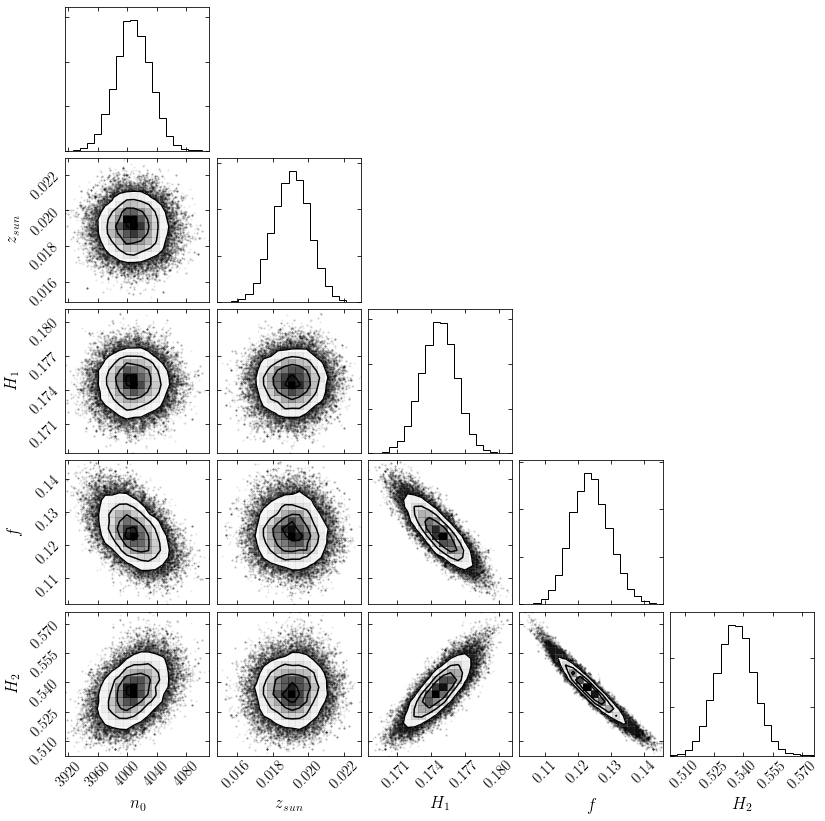

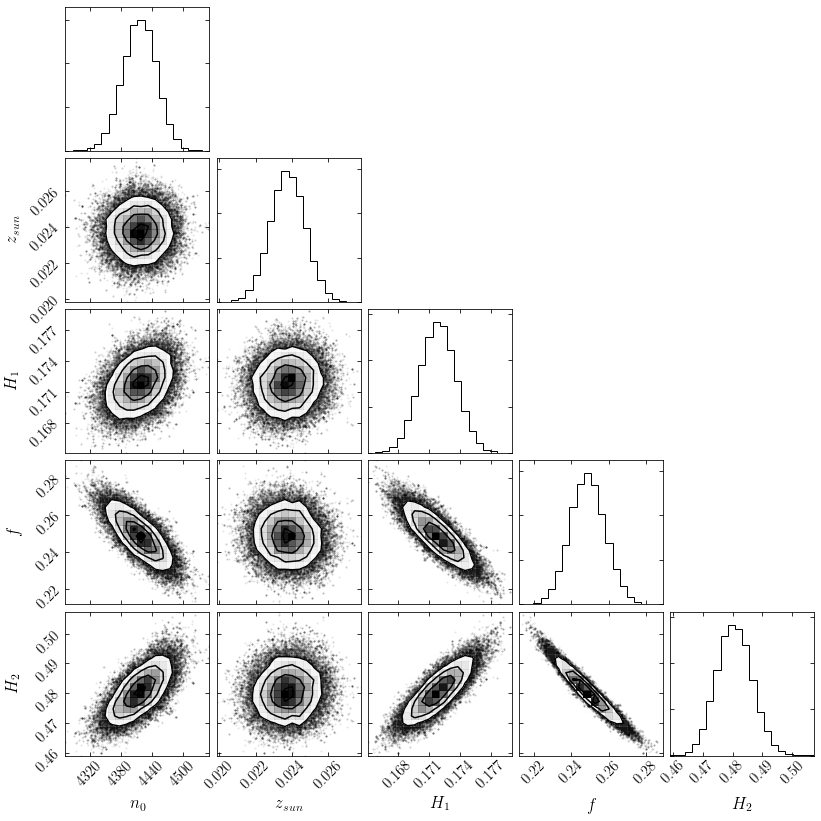

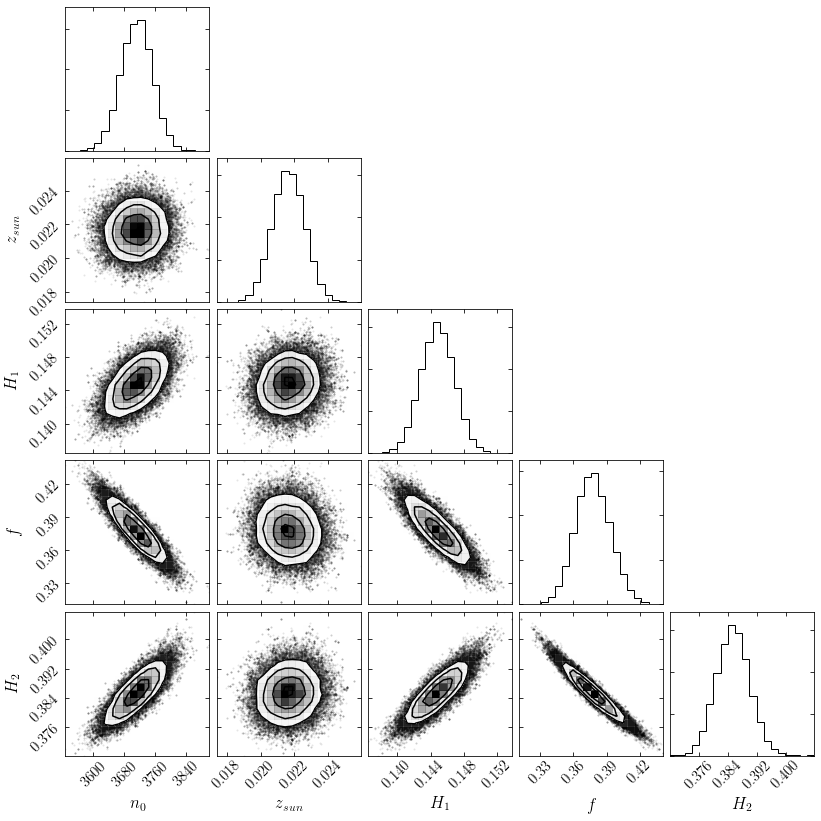

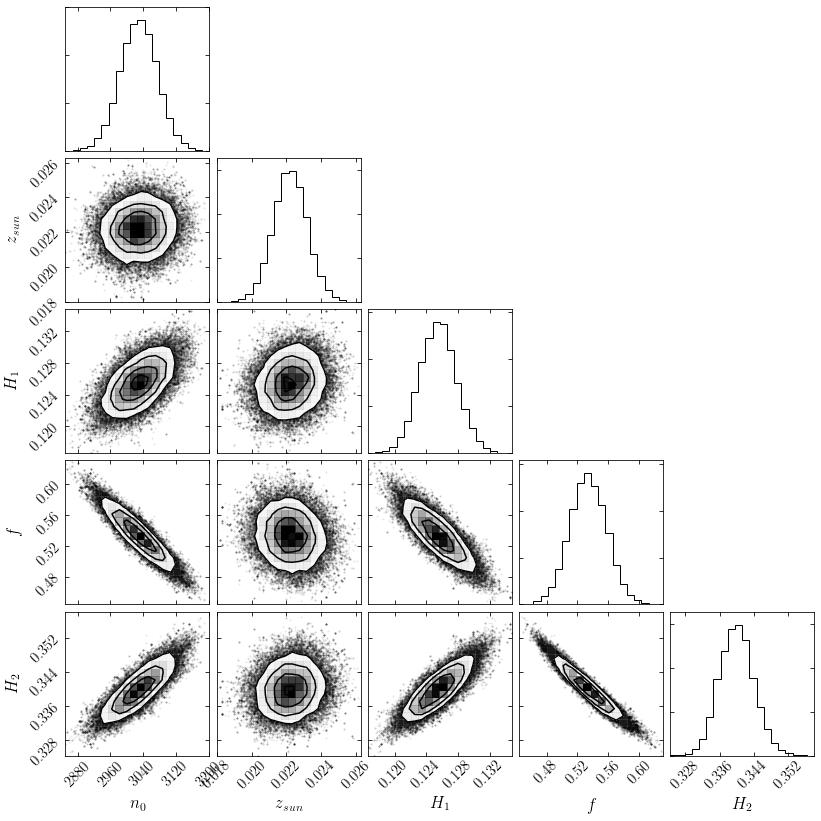

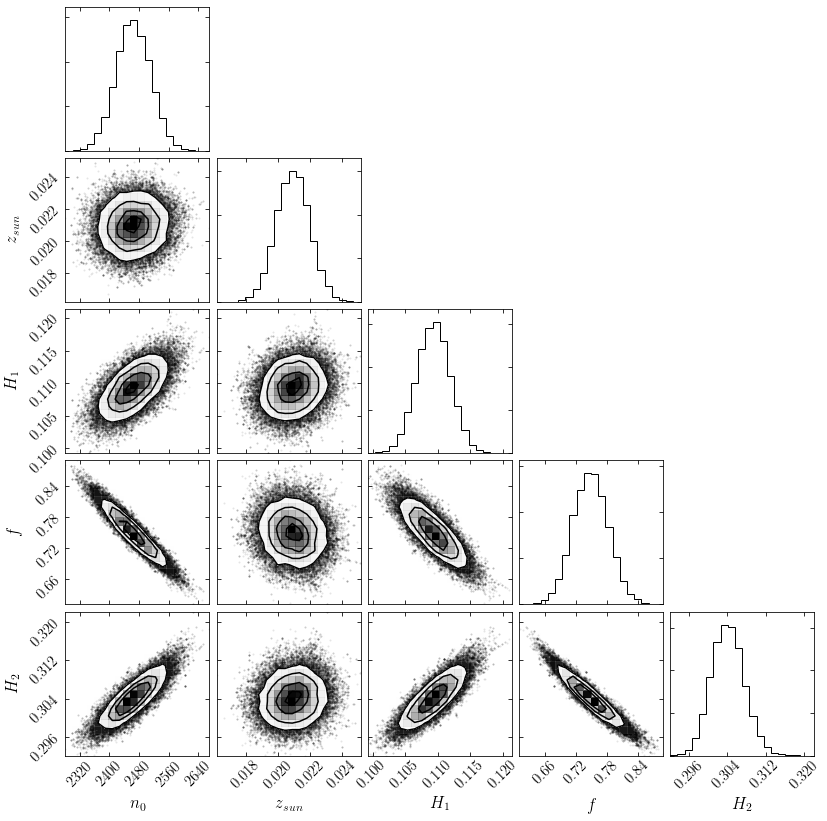

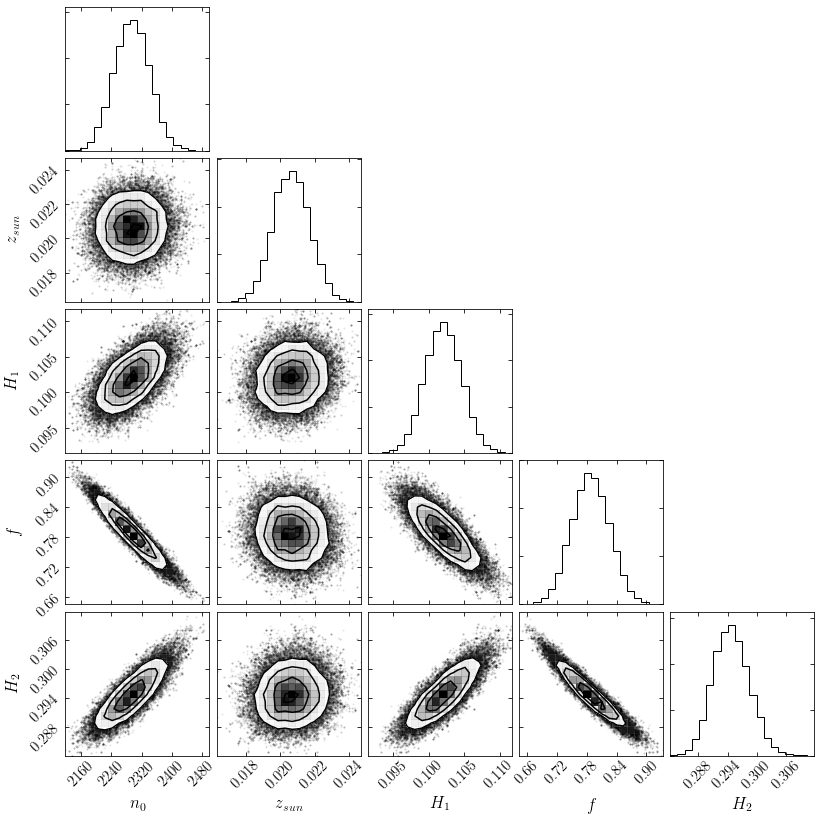

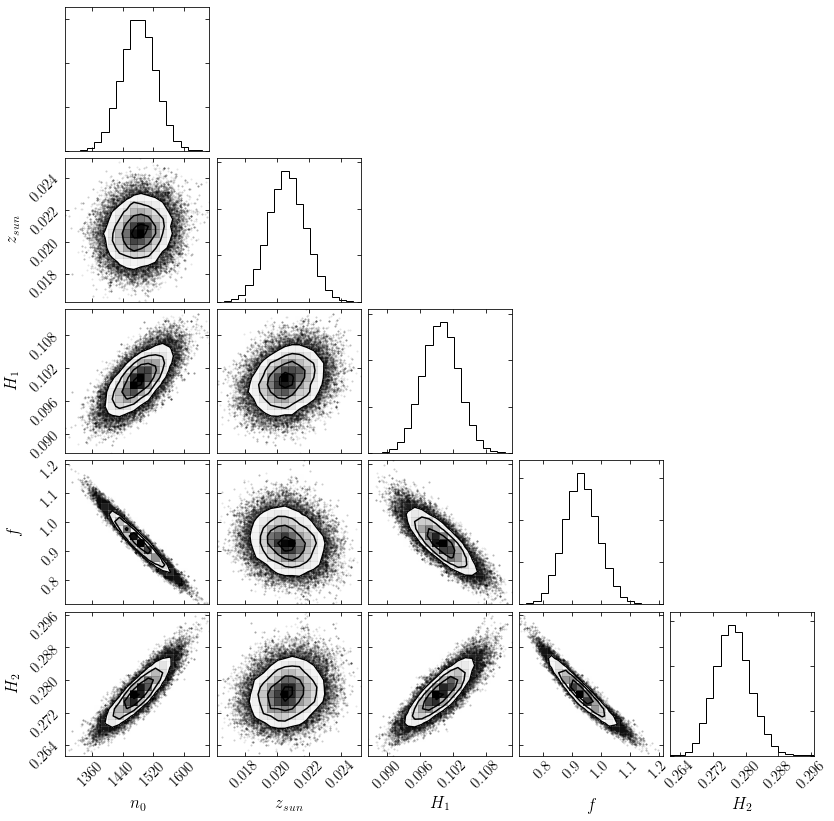

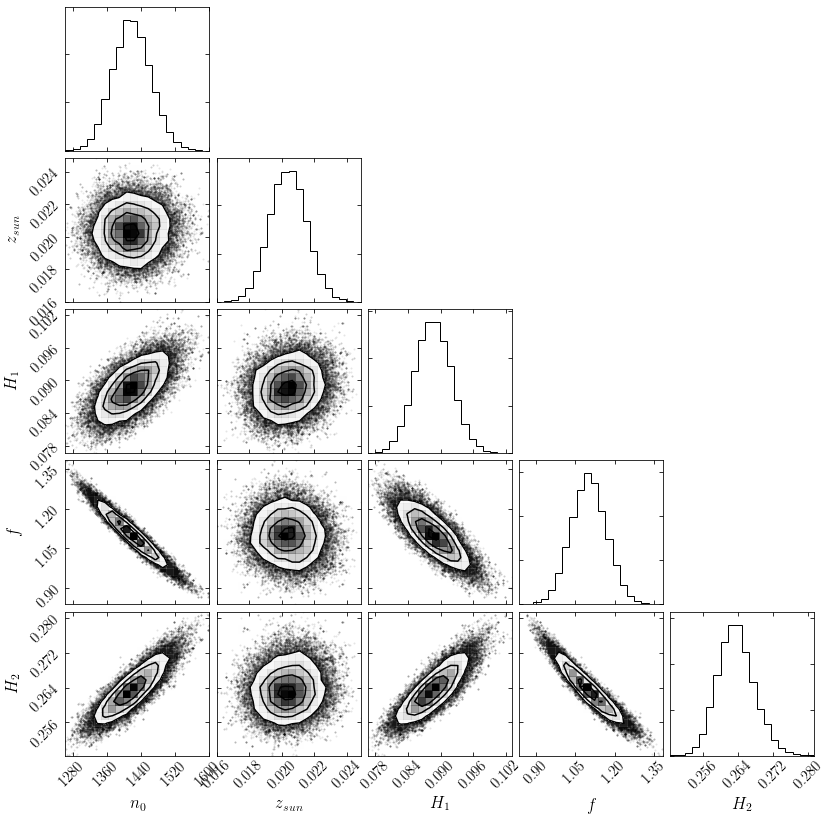

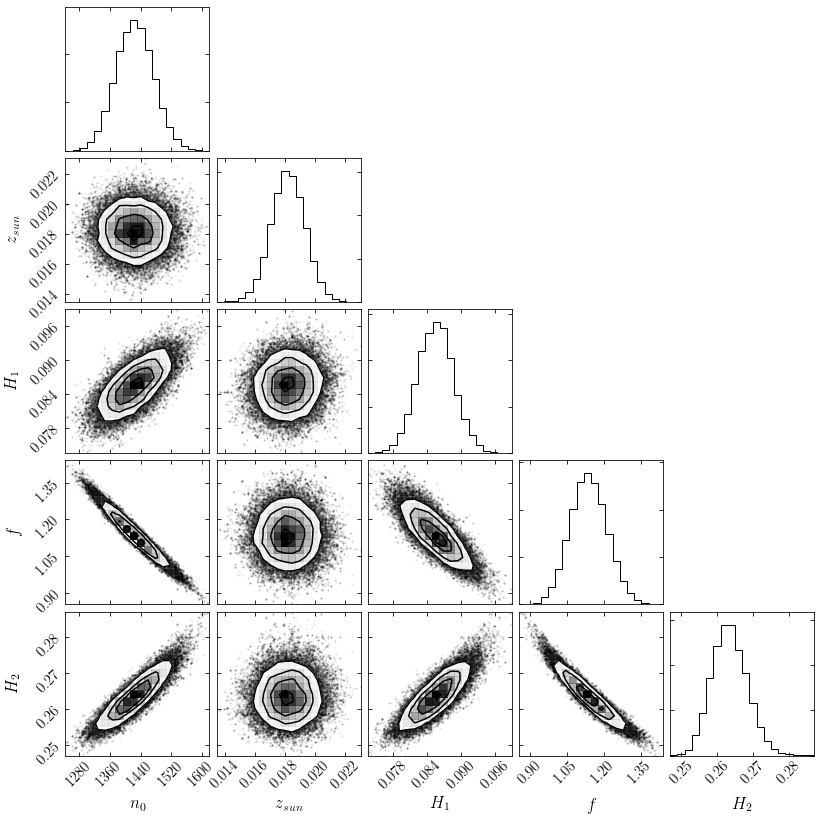

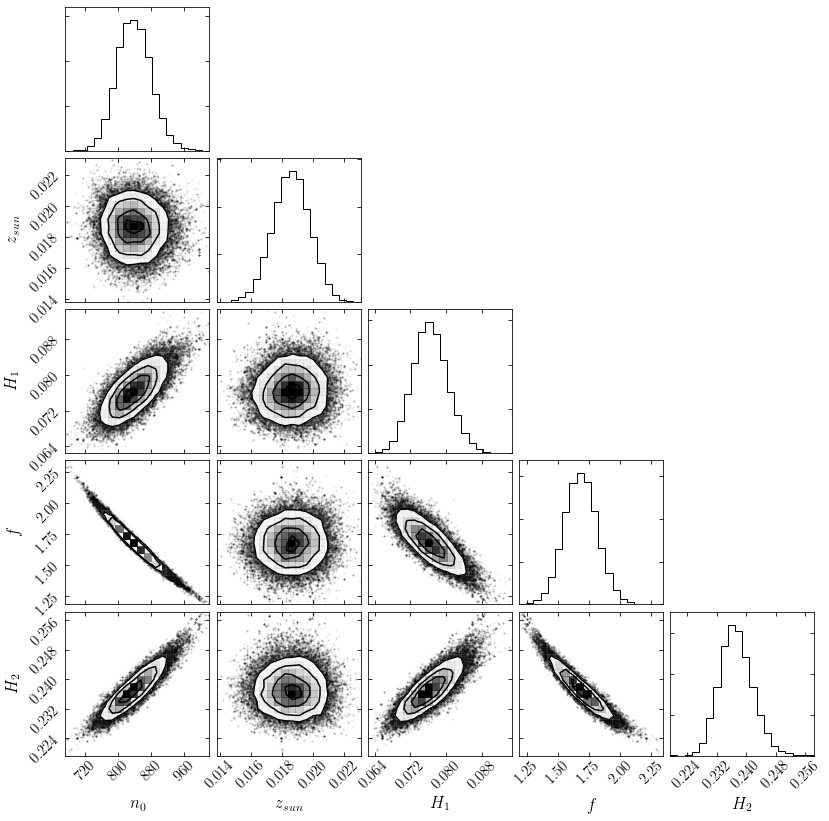

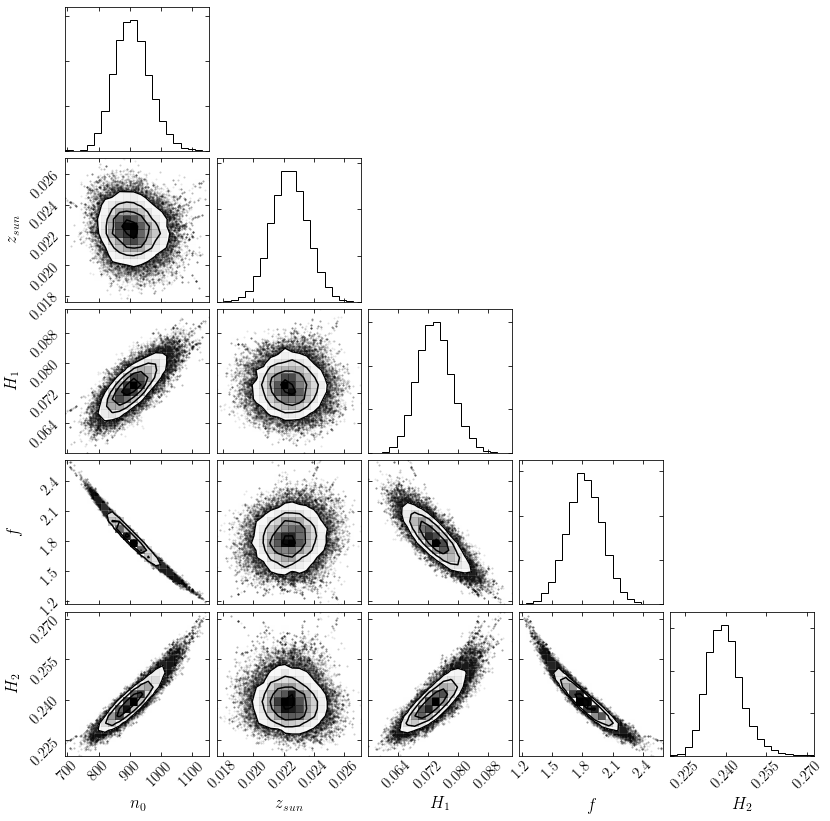

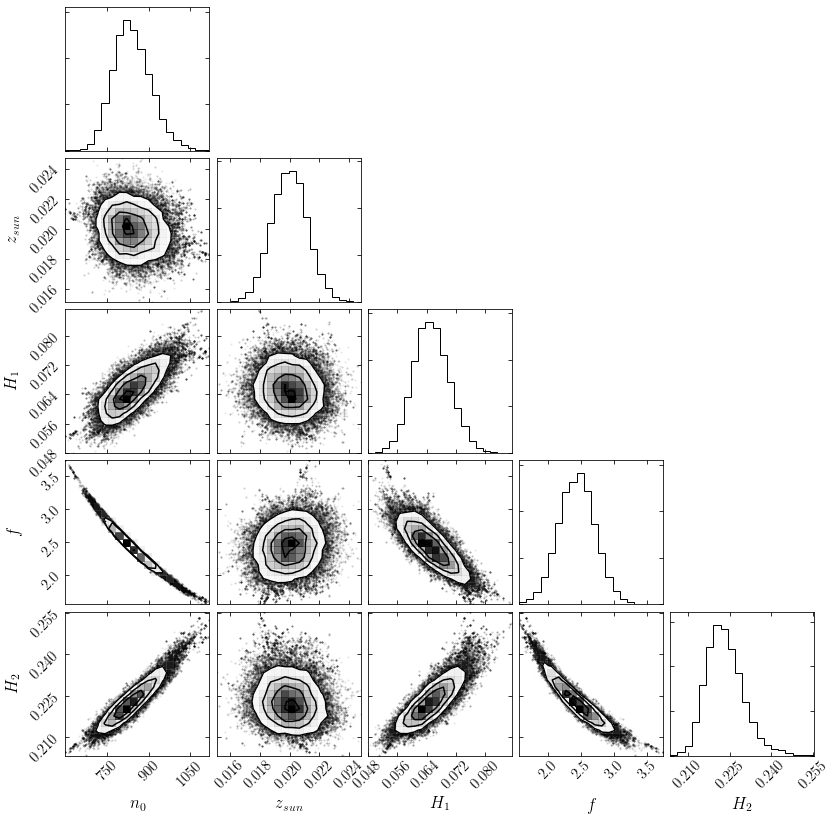

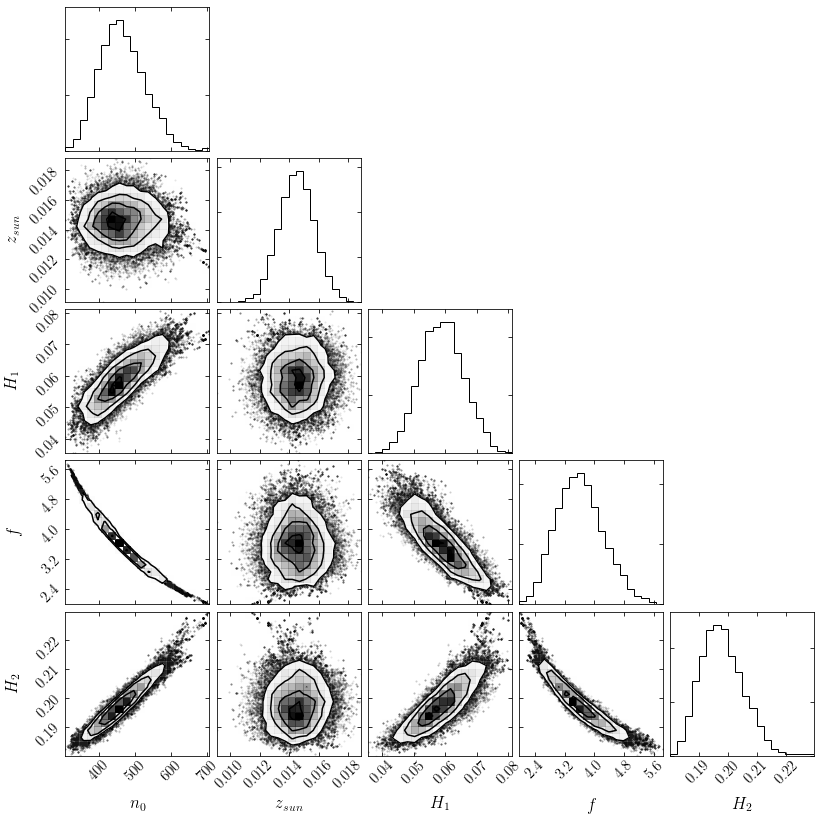

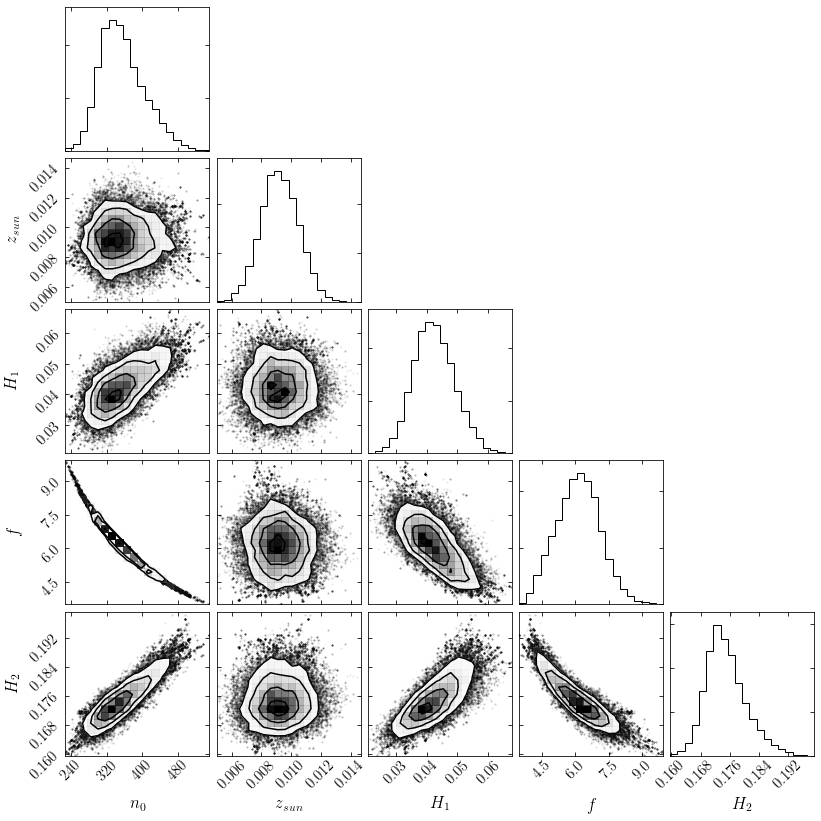

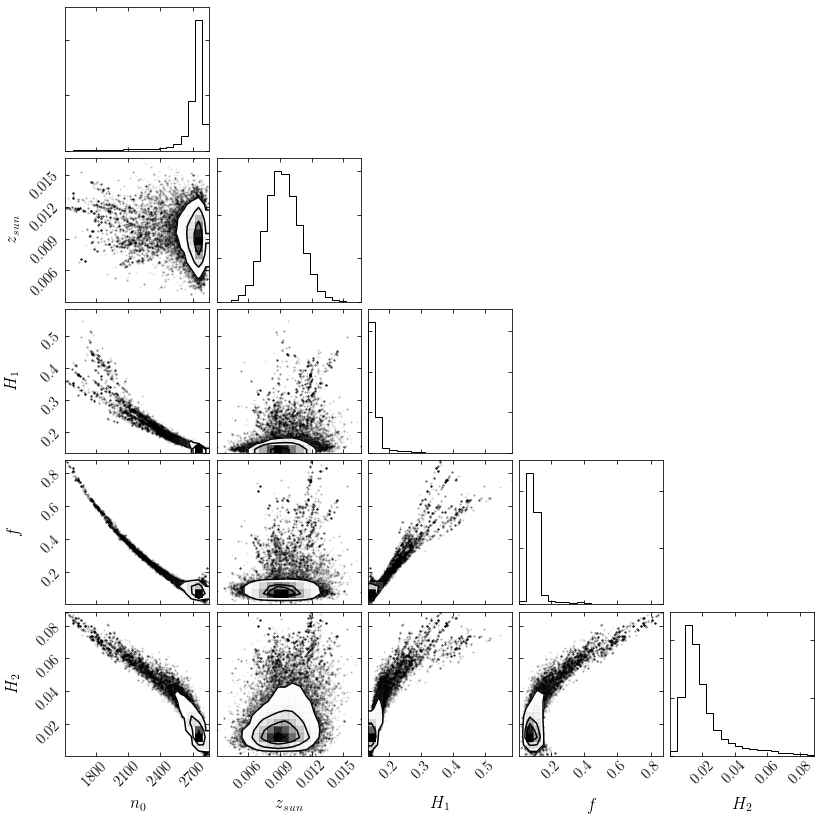

In [11]:
br_all= [[],[],[],[],[],[],[],[],[],[],[],
        [],[],[],[]]
for i in range(len(mag_data)):
    br_all[i]= ncount(mag_data[i],Mg_edges[i],bprp_edges[i],binw_all[i],guess_all[i],mcmc=True)

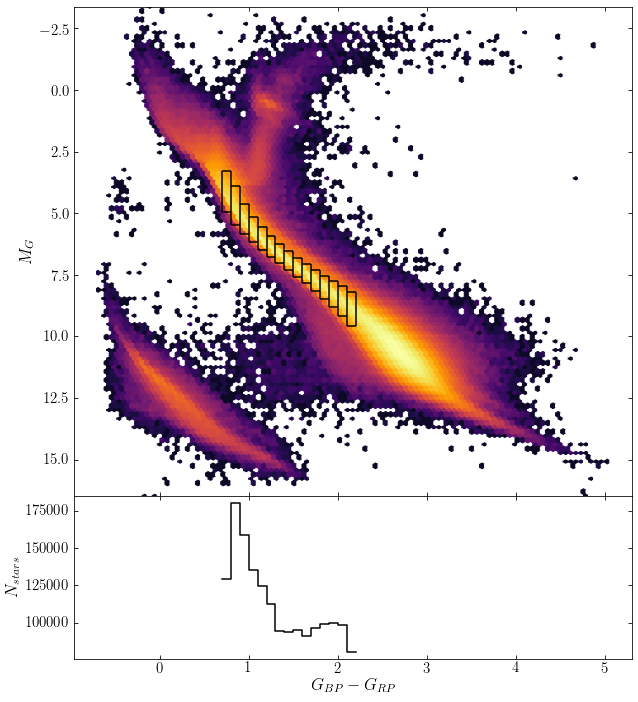

In [12]:
nstars= append(sum(br_all[0].N),[sum(b.N) for b in br_all])

mgplot= zeros((len(bprp_edges)+1,2))
mgplot[1:-1]= Mg_edges; mgplot[0]=Mg_edges[0]; mgplot[-1]=Mg_edges[-1]

colors = np.vstack(([1.,1.,1.,1.], plt.cm.inferno(np.linspace(0, 1, 256))))
cmap = mcolors.LinearSegmentedColormap.from_list('colormap', colors)

bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(10,12)

fig, (ax1,ax2)= subplots(2,sharex=True,gridspec_kw = {'height_ratios':[3, 1]})
fig.subplots_adjust(hspace=0)
ax1.hexbin(bprp,mg,bins='log',cmap=cmap,gridsize=100)
ax1.invert_yaxis()

for i in range(len(bprp_edges)):
    ax1.vlines(bprp_edges[i],mgplot[i][0],mgplot[i+1][1],color='k')
    if i<len(bprp_edges)-1:
        ax1.hlines(mgplot[i+1][0],bprp_edges[i],bprp_edges[i+1],color='k') 
        ax1.hlines(mgplot[i+1][1],bprp_edges[i],bprp_edges[i+1],color='k')
        
ax1.tick_params(axis='both')
ax1.set_ylabel(r'$M_G$')
ax2.set_xlabel(r'$G_{BP}-G_{RP}$')
ax2.tick_params(axis='both')
ax2.set_ylabel(r'$N_{stars}$')

ax2.step(bprp_edges,nstars,'k')

#savefig('cmd_hist.pdf',bbox_inches='tight')

In [22]:
def bootstrap(x,n_resamp):
    i= random.randint(0,len(x)-1,(n_resamp,len(x)))
    x_boot= x[i]
    m_boot= nanmedian(x_boot,axis=1)
    m= mean(m_boot)
    sigma= std(m_boot)
    return m,sigma

z0= array([b.z0_mcmc[0] for b in br_all])
avez0, sig= bootstrap(z0,100000)
 
print('The average value for zsun is: ', round(avez0*1000,1),' +/- ',round(sig*1000,1), ' pc.')

The average value for zsun is:  20.3  +/-  0.7  pc.


[]

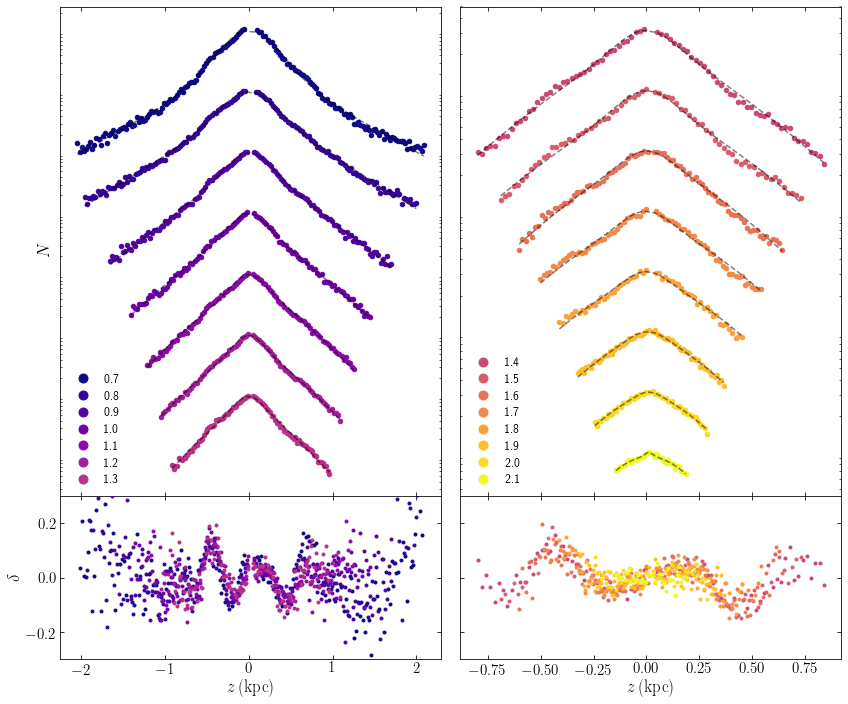

In [23]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(14,12)

fig, (ax,res) = plt.subplots(nrows=2, ncols=2, gridspec_kw = {'height_ratios':[3, 1]})
fig.subplots_adjust(hspace=0,wspace=0.05)

ax[0].set_ylabel(r'$N$')
res[0].set_ylabel(r'$\delta$')


#MCMC BEST FIT
for i,b in enumerate(br_all[::-1]):
    
    # OPTION 2: Shift by the same z0
    mbin= b.zbin+avez0
    Model= b.n_model(b.psech,b.zbin)
    
    N= b.N/max(Model)
    N_err= sqrt(b.N)/max(Model)
    Model= Model/max(Model)
    
    k=1 if (i<(len(br_all))/2) else 0
    
    ax[k].semilogy(mbin,Model*10**(i*(1-k/2)),'k--',alpha=0.5,zorder=30-i)  
    ax[k].semilogy(mbin,N*10**(i*(1-k/2)),'.',
                   color=plt.cm.plasma(1./(bprp_edges[-2]-bprp_edges[0])*(bprp_edges[-(i+2)]-0.7)),
                   label=str(round(bprp_edges[-(i+2)],1)),ms=9)
    
    handles, labels = ax[k].get_legend_handles_labels()
    ax[k].legend(handles[::-1], labels[::-1],markerscale=2,loc=3,frameon=False) 
    ax[k].set_yticks([])
   

    res[k].plot(mbin,(N-Model)/Model,'.',color=plt.cm.plasma(1./(bprp_edges[-2]-bprp_edges[0])*(bprp_edges[-(i+2)]-0.7)),
                label=str(round(bprp_edges[i],1)),zorder=20-i) 
    res[k].set_ylim([-0.3,0.3])
    res[k].set_xlabel(r'$z\,(\mathrm{kpc})$')
    res[k].tick_params(axis='both')

res[1].set_yticklabels([])


#savefig('ncounts.pdf',bbox_inches='tight')

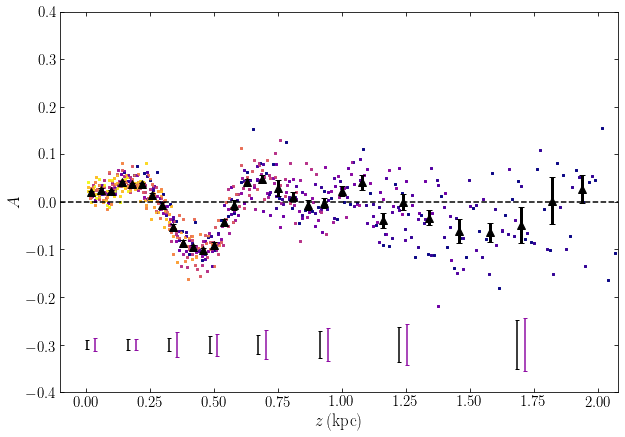

In [26]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(10,7)

zA_bins= append(append(append(arange(0.,0.64,0.04),arange(0.66,0.97,0.06)),arange(1.04,1.3,0.08)),arange(1.4,2.1,0.12))

y= empty(len(zA_bins)-1)
y_err= empty(len(zA_bins)-1)
sig= empty(len(y))
A_b= empty(len(zA_bins)-1)
Aerr_b= empty(len(y))
N_len= empty(len(y))

for i in range(len(y)):
    tot=[]
    tot_err=[]
    for j,b in enumerate(br_all):
        zA, A, A_err= b.calc_A(z0=avez0)
        tot= append(tot,A[(zA>zA_bins[i])*(zA<zA_bins[i+1])])
        tot_err= append(tot_err,A_err[(zA>zA_bins[i])*(zA<zA_bins[i+1])])
        
        plot(zA,A,'.',color=plt.cm.plasma(1./(bprp_edges[-2]-bprp_edges[0])*(bprp_edges[j]-0.7)),ms=2)

    y[i]= median(tot)
    y_err[i]= median(tot_err)
    sig[i]= std(tot)
    A_b[i], Aerr_b[i]= bootstrap(tot,10000)
    N_len[i]= len(tot)
    
mid = [(zA_bins[i]+zA_bins[i+1])/2. for i in range(len(y))]

i_err= 4
errorbar(mid,A_b,yerr=Aerr_b,color='k',fmt='^',ms=8,capsize=3.,lw=3,zorder=100)
errorbar(array(mid[::i_err])-0.015,A_b[::i_err]*0.-0.3,yerr=y_err[::i_err],fmt='.',ms=0,capsize=2.,color='k')
errorbar(array(mid[::i_err])+0.015,A_b[::i_err]*0.-0.3,yerr=sig[::i_err],fmt='.',ms=0,capsize=2.,color=plt.cm.plasma(0.3))
axhline(0.,ls= '--',color='k')
ylabel(r'$A$')
xlabel(r'$z\,(\mathrm{kpc})$')
ylim([-0.4,0.4])
xlim([-0.1,2.08])

savefig('asymmetry.pdf',bbox_inches='tight')

In [27]:
def likeli(params,data):
    z= data[1]
    N= data[0]
    
    if (params[4]>5. or params[4]<0):
        return inf
    if (params[3]>10. or params[3]<0.):
        return inf
    if (params[2]<0. or params[2]>5.):
        return inf
    if (params[1]<-0.1 or params[1]>0.1):
        return inf
    
    model= nasym_model(params,z)

    loglike= -model+N*log(model)
    return -sum(loglike)
        
def nasym_model(params,zdata):
    ln_n0,zsun,H1,f,H2 = params
    n0= 10.**(ln_n0)
    Nobs= n0*(1./cosh((zdata+zsun)/(2.*H1))**2+f*1./cosh((zdata+zsun)/(2.*H2))**2)
    zobs= zdata+zsun
 
    Aobs_p= A_func(zobs[zobs>0])
    Aobs_n= A_func(-zobs[zobs<0])

    n= zeros(len(zdata))

    n[(zobs<0)]= Nobs[(zobs<0)]*(1-Aobs_n)
    n[(zdata+zsun>0)]= Nobs[(zobs>0)]*(1+Aobs_p)

    return n

A_func= CubicSpline(mid, A_b)

In [29]:
def calc_mcmc(data,guess,nsteps):
        ndim= len(zsun_guess[0])
        nwalkers= round(nsteps*0.1)
        
        mask= [(data[1]>-2.08)*(data[1]<2.08)]
        fit= minimize(lambda x: likeli(x,[data[0],data[1]]),guess)
        pos= [fit.x+1e-3*np.random.randn(ndim) for i in range(nwalkers)]
        
        sampler= emcee.EnsembleSampler(nwalkers,ndim,lambda x:-likeli(x,[data[0][mask],data[1][mask]]))
        sampler.run_mcmc(pos,nsteps)

        samples= sampler.chain[:,(round(nsteps*0.1)):,:].reshape((-1,ndim))
        samples[:,0]= 10.**samples[:,0]
        
        return samples

In [30]:
zsun_guess= [[3.5,0.03,0.1,0.1,0.5],[3.5,0.03,0.1,0.1,0.5],[3.5,0.03,0.2,0.1,0.5],
            [3.5,0.03,0.2,0.1,0.4],[3.5,0.03,0.2,0.15,0.4],[3.5,0.03,0.2,0.15,0.4],[3.5,0.03,0.2,0.15,0.4],
            [3.5,0.03,0.2,0.15,0.4],[3.,0.03,0.2,0.15,0.4],[3.5,0.03,0.2,0.15,0.3],[3.5,0.03,0.2,0.25,0.4],
            [3.5,0.03,0.2,0.25,0.4],[3.,0.03,0.2,0.25,0.4],[3.5,0.03,0.2,0.25,0.4],[3.5,0.03,0.1,0.1,0.4]]
z0=zeros([len(br_all),3])
samples= empty([len(br_all),90000,5])

for i,b in enumerate(br_all):
    samples[i]= calc_mcmc([b.N,b.zbin],zsun_guess[i],1000)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [31]:
zsun_mcmc=[]
zsun_n=[]
zsun_p=[]
for s in samples:
    n0,z0,h1,f,h2= map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                                zip(*np.percentile(s, [16, 50, 84],
                                                                   axis=0)))
    zsun_mcmc= append(zsun_mcmc,z0[0])
    zsun_n= append(zsun_n,z0[1])
    zsun_p= append(zsun_p,z0[2])
    #fig = corner.corner(s,labels=["$n_0$", "$z_{sun}$", "$H_1$", "$f$", "$H_2$"])


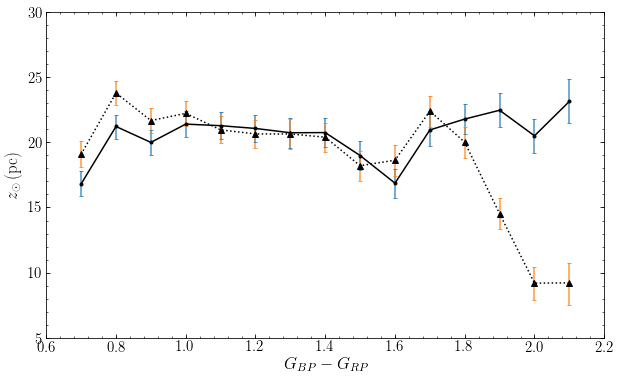

In [32]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(10,6)

bovy_plot.bovy_plot(bprp_edges[:-1],zsun_mcmc*1000.,
                    'k.-',
                    xrange=[0.6,2.2],
                    yrange=[5,30],
                   xlabel=r'$G_{BP}-G_{RP}$',
                   ylabel=r'$z_\odot\,(\mathrm{pc})$')  

errorbar(bprp_edges[:-1],zsun_mcmc*1000.,yerr=[zsun_n*1000.,zsun_p*1000.],marker='None',ls='None',alpha=0.8,capsize=2.)
br= [b.br for b in br_all]
old_zsun= array([b.z0_mcmc[0] for b in br_all])
zsun_err= array([[b.z0_mcmc[1],b.z0_mcmc[2]] for b in br_all])
plot(br,old_zsun*1000.,'k:',marker='^')
errorbar(br,old_zsun*1000.,yerr=zsun_err.T*1000.,marker='None',ls='None',alpha=0.8,capsize=2.)

savefig('zsun.pdf',bbox_inches='tight')

In [33]:
def bootstrap_mean(x,n_resamp):
    i= random.randint(0,len(x)-1,(n_resamp,len(x)))
    x_boot= x[i]
    m_boot= mean(x_boot,axis=1)
    m= mean(m_boot)
    #hist(m_boot,bins=51)
    sigma= std(m_boot)
    return m,sigma

In [35]:
print(np.round(array(bootstrap(old_zsun,10000))*1000.,1),'pc')
print(np.round(array(bootstrap(zsun_mcmc,10000))*1000.,1),'pc')

[20.3  0.7] pc
[20.8  0.3] pc


In [91]:
velquery= '''SELECT radial_velocity, radial_velocity_error,
ra, dec, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error
FROM gaiadr2.gaia_source
WHERE radial_velocity IS NOT Null AND parallax_over_error>5.
AND parallax IS NOT Null'''

In [92]:
out= query.query(velquery,local=False)
nick= 'gaia_vel'
query.cache.nickname(q,nick)

True

In [93]:
lb= bovy_coords.radec_to_lb(array(out['ra']),array(out['dec']),degree=True)
XYZ= bovy_coords.lbd_to_XYZ(lb[:,0],lb[:,1],1./out['parallax'],degree=True)
Rxy= numpy.sqrt(XYZ[:,0]**2.+XYZ[:,1]**2.)
pmllbb= bovy_coords.pmrapmdec_to_pmllpmbb(out['pmra'],out['pmdec'],
                                         out['ra'],out['dec'],degree=True)
UVW= bovy_coords.vrpmllpmbb_to_vxvyvz(out['radial_velocity'],pmllbb[:,0],pmllbb[:,1],
                                      lb[:,0],lb[:,1],1./out['parallax'],degree=True)

In [94]:
tindx= (out['parallax']/out['parallax_error'] > 5.)

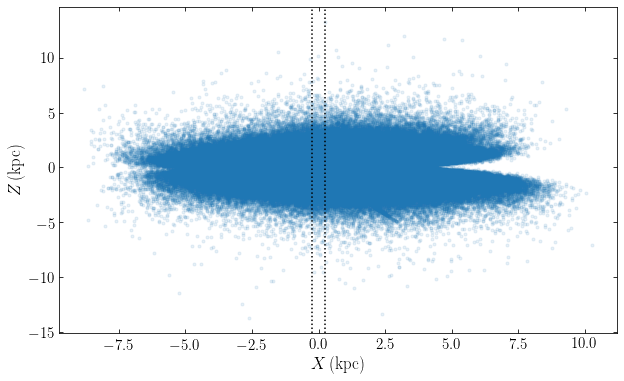

In [95]:
plot(XYZ[:,0],XYZ[:,2],'.',alpha=0.1)
xlabel(r'$X\,(\mathrm{kpc})$')
ylabel(r'$Z\,(\mathrm{kpc})$')
axvline(-0.25,color='k',ls=':')
axvline(0.25,color='k',ls=':')

In [96]:
indx= (Rxy < .25)

KeyboardInterrupt: 

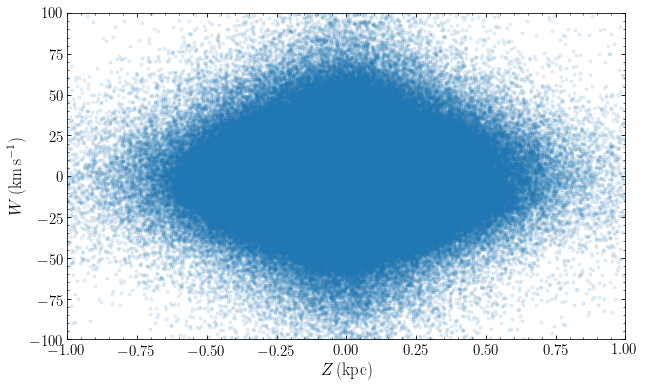

In [97]:
bovy_plot.bovy_plot(XYZ[indx,2],UVW[indx,2]-numpy.nanmedian(UVW[indx,2]),'.',alpha=0.1,
                   xrange=[-1.,1.],
                   yrange=[-100.,100.],
                   xlabel=r'$Z\,(\mathrm{kpc})$',
                   ylabel=r'$W\,(\mathrm{km\,s}^{-1})$')                   
sindx= numpy.argsort(XYZ[indx,2])
wind= 8000
showskip= wind
running_median_gaia= pandas.DataFrame(UVW[indx,2][sindx]-numpy.nanmedian(UVW[indx,2]))\
        .rolling(window=wind,center=True,min_periods=wind//2)\
        .apply(lambda x: numpy.nanmedian(x),raw=True)
plot(XYZ[indx,2][sindx][::showskip],running_median_gaia[::showskip],
     'k.-')

In [142]:
running_median_err_gaia= pandas.DataFrame(UVW[indx,2][sindx]-numpy.nanmedian(UVW[indx,2]))\
        .rolling(window=wind,center=True,min_periods=wind//2)\
        .apply(lambda x: 1.4826*numpy.nanmedian(numpy.fabs(x-numpy.nanmedian(x)))
                               /numpy.sqrt(numpy.sum(True^numpy.isnan(x))))

<ErrorbarContainer object of 3 artists>

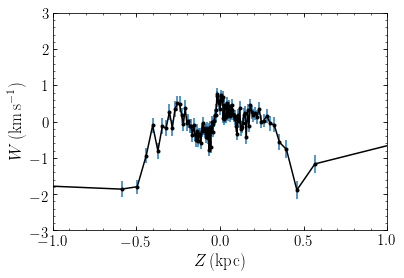

In [143]:
bovy_plot.bovy_plot(XYZ[indx,2][sindx][::showskip],running_median_gaia[::showskip],
                    'k.-',
                    xrange=[-1.,1.],
                    yrange=[-3.,3.],
                   xlabel=r'$Z\,(\mathrm{kpc})$',
                   ylabel=r'$W\,(\mathrm{km\,s}^{-1})$')                    
errorbar(XYZ[indx,2][sindx][::showskip],numpy.array(running_median_gaia[::showskip]),
         yerr=numpy.array(running_median_err_gaia[::showskip]),
         marker='None',ls='None')

In [98]:
binw1= 0.025
binw2= 0.1
bins= append(append(arange(-1.5,-0.5,binw2),
                    numpy.round(arange(-0.5,0.5+binw1,binw1),3)),
             arange(0.5+binw2,1.5+binw2,binw2))

vave= zeros(len(bins)-1)
vave_b= zeros(len(bins)-1)
sig= zeros(len(bins)-1)
sig_b= zeros(len(bins)-1)

for i in range(len(bins)-1):
    sample= UVW[indx,2][(XYZ[indx,2]>bins[i])*(XYZ[indx,2]<bins[i+1])]-numpy.nanmedian(UVW[indx,2])
    vave[i]= median(sample)
    vave_b[i], sig_b[i]= bootstrap_median(sample,10000)
    sig[i]= 1.4826*median(abs(sample-numpy.nanmedian(sample)))/sqrt(len(sample))

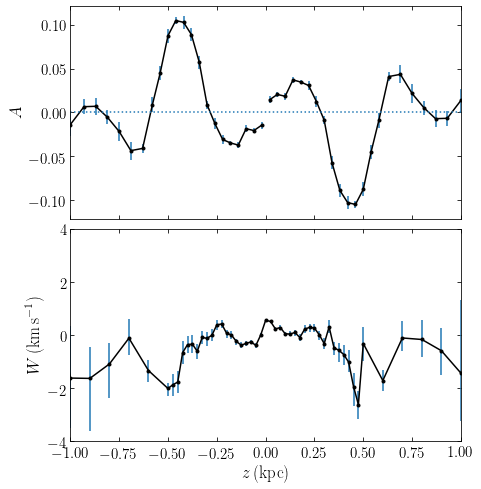

In [101]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(7,8)

fig,(ax1,ax2)= subplots(2,sharex=True)
fig.subplots_adjust(hspace=0.05)

ax1.plot(mid,A_b,'k.-')
ax1.plot(-array(mid),-A_b, 'k.-')
ax1.errorbar(mid,A_b,yerr= Aerr_b,marker='None',ls='None',c='C0')
ax1.errorbar(-array(mid),-A_b, yerr= Aerr_b,marker='None',ls='None',c='C0')
ax1.axhline(0.,ls=':')

ax2.plot(bins[1:],vave,'k.-')
ax2.errorbar(bins[1:],vave_b,yerr=sig_b,marker='None',ls='None')
ax2.set_xlim([-1,1])
ax2.set_ylim([-4,4])

ax1.set_ylabel(r'$A$')
ax2.set_xlabel(r'$z\,(\mathrm{kpc})$')
ax2.set_ylabel(r'$W\,(\mathrm{km\,s}^{-1})$')

savefig('summary_plot.pdf',bbox_inches='tight')

(-0.1, 2.08)

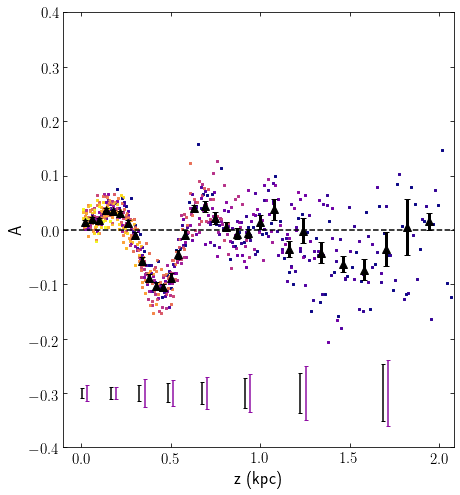

In [100]:
y= empty(len(zA_bins)-1)
y_err= empty(len(zA_bins)-1)
sig= empty(len(y))
A_b= empty(len(zA_bins)-1)
Aerr_b= empty(len(y))
N_len= empty(len(y))

for i in range(len(y)):
    tot=[]
    tot_err=[]
    for j,b in enumerate(br_all):
        zA, A, A_err= b.calc_A(z0=0.019)
        tot= append(tot,A[(zA>zA_bins[i])*(zA<zA_bins[i+1])])
        tot_err= append(tot_err,A_err[(zA>zA_bins[i])*(zA<zA_bins[i+1])])
        
        plot(zA,A,'.',color=plt.cm.plasma(1./(bprp_edges[-2]-bprp_edges[0])*(bprp_edges[j]-0.7)),ms=2)

    y[i]= mean(tot)
    y_err[i]= median(tot_err)
    sig[i]= std(tot)
    A_b[i], Aerr_b[i]= bootstrap_median(tot,10000)
    N_len[i]= len(tot)
    
mid = [(zA_bins[i]+zA_bins[i+1])/2. for i in range(len(y))]

i_err= 4
errorbar(mid,A_b,yerr=Aerr_b,color='k',fmt='^',ms=8,capsize=3.,lw=3,zorder=100)
errorbar(array(mid[::i_err])-0.015,A_b[::i_err]*0.-0.3,yerr=y_err[::i_err],fmt='.',ms=0,capsize=2.,color='k')
errorbar(array(mid[::i_err])+0.015,A_b[::i_err]*0.-0.3,yerr=sig[::i_err],fmt='.',ms=0,capsize=2.,color=plt.cm.plasma(0.3))
axhline(0.,ls= '--',color='k')
ylabel('A')
xlabel('z (kpc)')
ylim([-0.4,0.4])
xlim([-0.1,2.08])